In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import truncnorm, norm, skewnorm

from utils import plot_distribution

In [2]:
# plot settings

sns.set(style="whitegrid")
np.random.seed(42)
title_font = 18
labels_font = 16
text_font = 14
tick_font = 12
images_dir = "images/evaluation_1"
os.makedirs(images_dir, exist_ok=True)

# How Good is My Model? Part 1

This notebook supports [this](https://afnan-sultan.github.io/posts/2025/08/evaluation1/) blog post by plotting the different plots shown in it. This is part one of a series that will go roughly as shown in the image below

![image](images/evaluation_1/journey.png)

This notebook guides one through:

1. Plotting the distribution of a dataset in an informative fashion
2. Simulate the error distribution of a model on a test set (i.e., residuals distribution)
3. Simulate different distribution shapes to visualize the expected vs. typical values of a distribution
4. Simulate sampling variability and how one sample is insufficient to capture the model's true performance

TL;DR
![image](images/evaluation_1/mindmap.png)

---

# Exploring Aqueous solubility datasets

In the folder `data`, one can refer to the `README` to see different datasets for aqueous solubility gathered from the literature.

The `extract_relevant_fields_and_convert_to_LogS.py` file is used to process these files so that it:
1. Unifies the measuring unit for all datasets to be the base_10 logarithm of the molar unit (Mole/Liter).
2. For databases that contain multi-source datasets:
    1. Extract dataset by source
    2. Export only datasets that contain at least 1000 molecule → restricting our datasets to moderate size as lower sizes would require different line of analysis (And yes, 1000 is kinda arbitrary, one can look deeper into what would be a good threshold.)

## A thought...
The hope of step 2 was to isolate experimental conditions of the aggregated datasets. After I have read the paper "[will we ever be able to accurately predict aqueous solubility?]()" by Llompart *et al.*, I understood that the term aqueous solubility comes in different flavors. Namely,
- Intrinsic solubility
- Apparent solubility
- kinetic solubility
- Water solubility.

The same molecule would have a different solubility value for each term of these. So, when training a model to predict aqueous solubility, if a model does not have access to this information, one should **not** expect the model to perform nicely!
<br>A model might predict a value of -2 LogS which might be accurate if one is predicting apparent solubility, but grossly off if one is predicting intrinsic solubility.

So, it felt important to me that one has such information for each molecule to either train a model per experiment or introduce these experiment conditions as features of the molecules to help the model keep track.

## ... and a challenge
I thought that isolating a dataset by source from the large databases would be enough to do so. However, the dataset tracking done by Llompart *et al.* revealed that even the individual datasets in the big databases are themselves a collection of different experiments in the literature!
<br>Unfortunately, none of these databases contained enough information about the solubility subtype and other important conditions like temperature and pH.

Check the `README` to get a better idea on which metadata were included by which database.

Below, I plot the distribution of eight datasets that contained at least 1000 molecules. One can notice the following:

1. AstraZeneca and BioGen are first-hand reference. The conditions are specified in the corresponding data repository for the earlier, and in the manuscript for the latter.
2. ESol is a second-hand reference. It contains three different collections from in-house and external datasets, but further details about the metadata were not shared.
3. The SOMAS and AqSolDB subsets are N-1 reference from the corresponding database. The superset databases included little metadata about the experimental conditions. Scavenging the information from each experimental reference is a mountain to climb for another time.

## Plotting preferences
I have become fond of plotting a dataset distribution as shown below.
1. The histogram gives me a clean feeling about the number of molecules per value range.
2. The KDE is an additional layer to overlay the shape of the distribution.
3. The boxplot is cleanly segmenting the distribution into quartiles to have a quick intuition about the location of the median value, skewness, and the outliers.
    - The green triangle is the mean of the distribution.

solubility_az.csv: 0 duplicate SMILES
solubility_biogen.csv: 0 duplicate SMILES
ESol.csv: 16 duplicate SMILES
SOMAS_25_OChem.csv: 0 duplicate SMILES
SOMAS_25_Frontiers in Oncology 2020; 10.doi.10.3389_fonc.20.csv: 0 duplicate SMILES
AqSolDB_B.csv: 0 duplicate SMILES
AqSolDB_C.csv: 0 duplicate SMILES
AqSolDB_A.csv: 0 duplicate SMILES


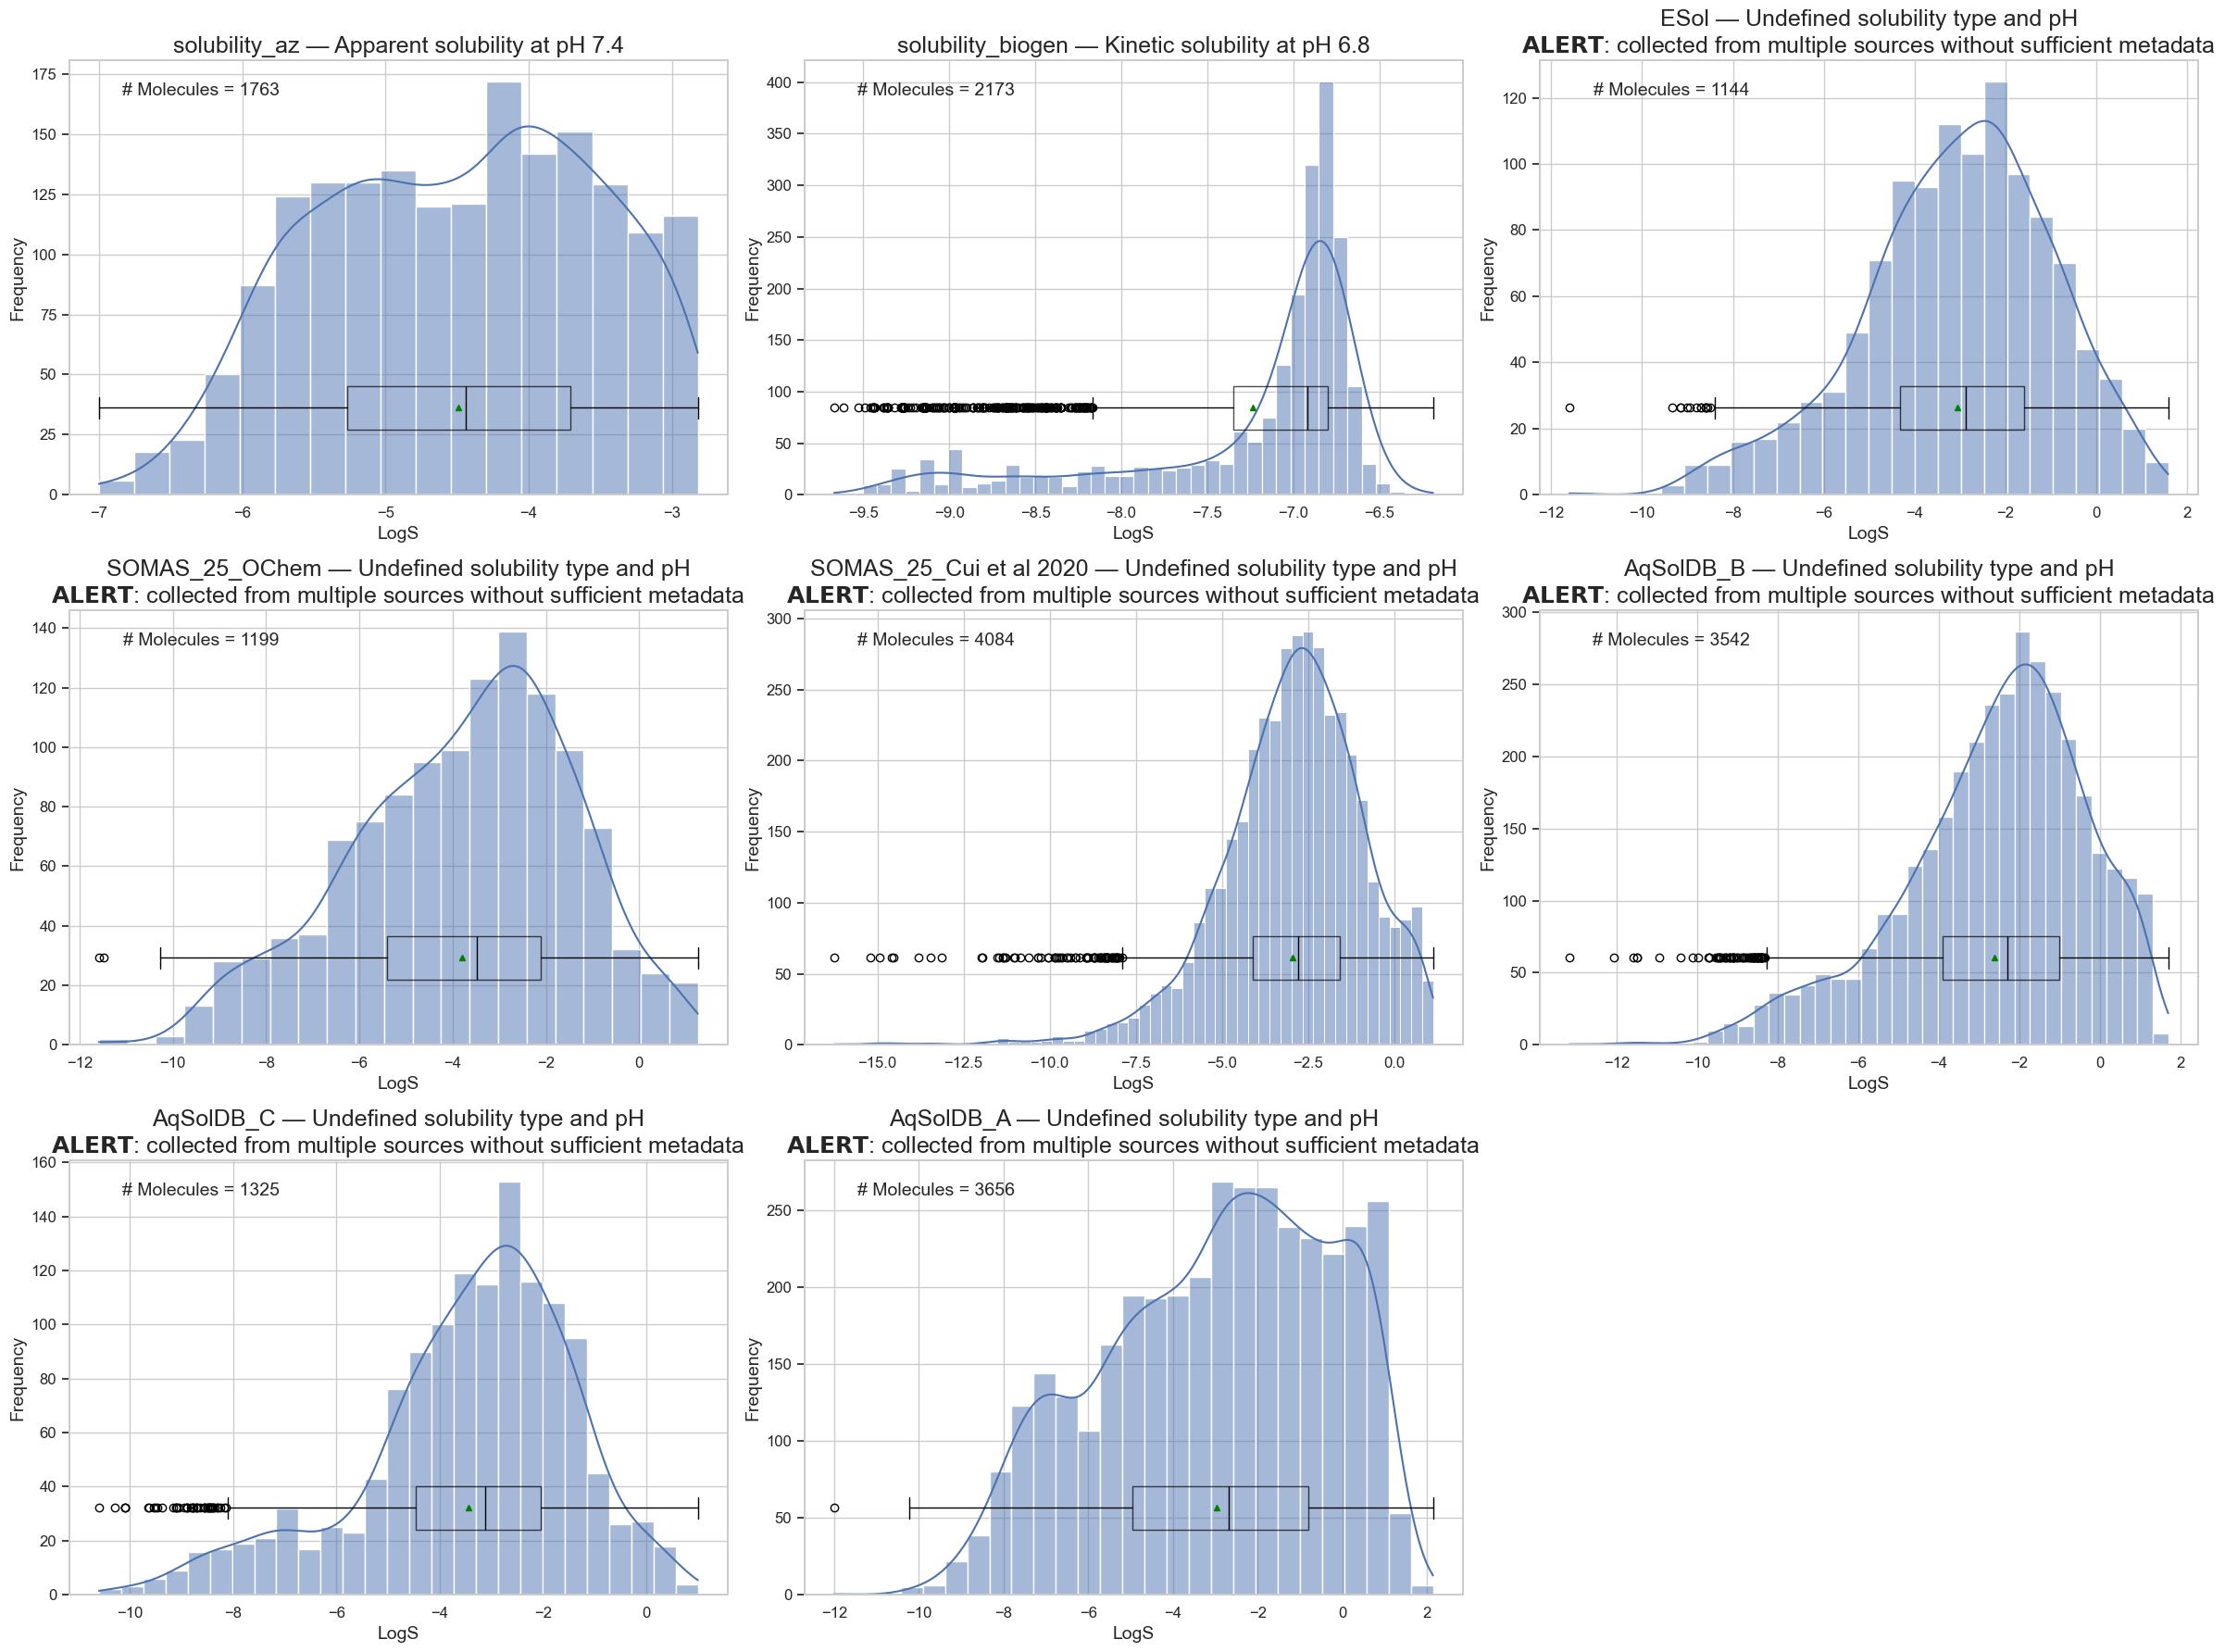

In [3]:
# ---------- Analyze all 'by_source' datasets ----------
input_dir = Path("data/aqueous_solubility/by_source")
def get_priority(file: Path) -> int:
    fname = file.name.lower()
    if 'az' in fname:
        return 0
    elif 'biogen' in fname:
        return 1
    elif 'esol' in fname:
        return 2
    else:
        return 3

csv_files = sorted(input_dir.glob("*.csv"), key=get_priority)

n_files = len(csv_files)
ncols = 3
nrows = int(np.ceil(n_files / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
axes = axes.flatten()

# Collect all datasets
all_dfs = []

for i, file in enumerate(csv_files):
    df = pd.read_csv(file)

    # Keep only SMILES and LogS
    df = df[['SMILES', 'LogS']].dropna()
    all_dfs.append(df)  # Accumulate for messy_population

    # Check for duplicates
    duplicate_count = df.duplicated(subset='SMILES').sum()
    print(f"{file.name}: {duplicate_count} duplicate SMILES")

    # Plot title logic
    fname = file.name.lower()
    if 'az' in fname:
        title = f"{file.stem} — Apparent solubility at pH 7.4"
    elif 'biogen' in fname:
        title = f"{file.stem} — Kinetic solubility at pH 6.8"
    else:
        stem = file.stem
        if "Frontiers in Oncology 2020" in stem:
            stem = stem.replace("Frontiers in Oncology 2020; 10.doi.10.3389_fonc.20", "Cui et al 2020")
        title = f"{stem} — Undefined solubility type and pH\n" \
        r"$\bf{ALERT}$: collected from multiple sources without sufficient metadata"


    # Plot
    df['LogS'].name = title
    plot_distribution(df['LogS'], ax=axes[i], x_label="LogS")

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'sol_datasets.png'))

plt.show()

# Simulation land


I will not use any of these datasets yet because, as one will see later, they are quite messy. Right now, I want to understand a couple of concepts in an ideal situation before I introduce the messiness of the world to it.

So, this notebook is mostly simulated data and plots.

## Simulate imaginary population

I will start by simulating an imaginary *population* that will contain a million datapoint for the solubility type we wish to model.

I noticed from the plots above that many datasets contain values between -12 and 2 LogS, so, I will make my imaginary population in this range.

I will imagine that this population follows a normal distribution, and I will calculate the mean and standard deviation from my population range as follows.
- The mean is set to the middle of the range
- Standard deviation for a normal distribution is known to span three units on each side of the mean
- A normal distribution follows the 68-95-99.7 rule (i.e., 68% of the data are withing one standard deviation of the mean, 95% are withing two standard deviations, and 99.7% are within three standard deviations)

This imaginary population is a simulation of the **real** world.
<br>In the **real unmeasured world**, each molecule has a specific LogS value and the LogS values of all molecules follow some distribution.
<br>In the **measured reality**, just as seen in the above plot for the different datasets, we only have access to **some** parts of this unmeasured reality with varying frequency.

So, because I am in simulation land, and I can do whatever I want, I choose to start from an imaginary true state of the world. And I will be drawing samples and distributions based on this imaginary population.

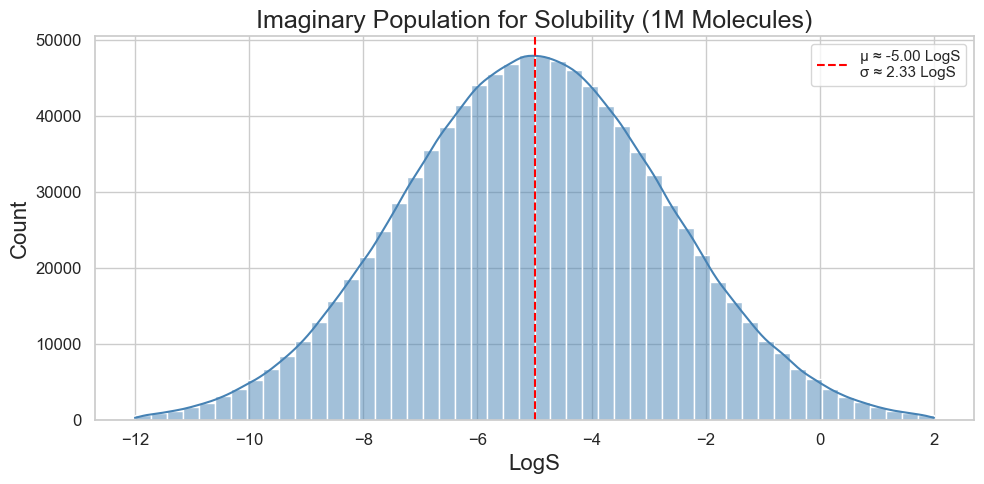

In [4]:
# ---------- parameters ----------
N       = 1_000_000               # number of molecules
lower   = -12                     # LogS
upper   = 2                       # LogS
mu      = (upper + lower) / 2     # Mean (µ)
sigma   = (upper - lower) / 6     # Standard Deviation (σ)

# ---------- draw from truncated normal ----------
a, b = (lower - mu) / sigma, (upper - mu) / sigma
imaginary_population = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=N)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(imaginary_population, bins=50, kde=True, color='steelblue', ax=ax)

# red-dashed line at realized mean
ax.axvline(imaginary_population.mean(), color='red', linestyle='--',
           label=f'μ ≈ {mu:.2f} LogS\nσ ≈ {sigma:.2f} LogS')


ax.set_title(f"Imaginary Population for Solubility ({N/1000000:.0f}M Molecules)", fontsize=title_font)
ax.set_xlabel("LogS", fontsize=labels_font)
ax.set_ylabel("Count", fontsize=labels_font)
ax.tick_params(axis='both', labelsize=tick_font)
ax.legend()
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'population.png'))

plt.show()

## Simulate Test Predictions

I will assume that I have finished training a model on a subset of this population. Now, I will imagine testing it on 400 molecules.

The error of a model is the difference between the true values and the predicted values. So, I will first draw 400 values from my imaginary population to work as my **test set's true values**.

In [5]:
# Select a test set
test_size = 400
test_true = np.random.choice(imaginary_population, size=test_size, replace=False)

Then I will simulate an error for these 400 molecules.

Our data ranges from -12 to 2 LogS, which is 14 units. So, I will assume that my model is predicting a normal distribution of errors with mean zero and standard deviation of 1 (i.e., 68% of the predictions are between -1 and 1 LogS). Which would be quiet descent for the number of units being modeled (in a purely subjective statistical sense... no idea whether a chemist would agree with this statement).

The average value of this distribution will be the `Expected` error value of my model. Additionally, the plot is highlighting two cases of high and low frequency error values to be approximately produced by the model.

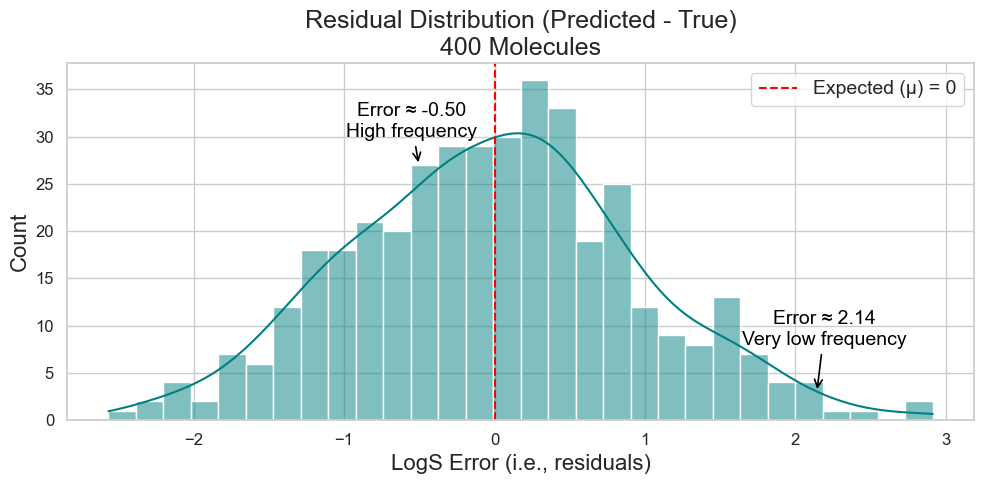

In [6]:
# Simulate predictions
rng = np.random.default_rng(42)
mu_A = 0
sigma_A = 1

# I am simulating the noise, add it to the tru values, and then subtract it again to get the error. This a nonsense step of course, but I am merely doing it to show what error or residual actually mean, and how it is calculated.
noise_A = rng.normal(mu_A, sigma_A, size=test_size)
test_pred_A = test_true + noise_A
residuals_A = test_pred_A - test_true  # Same as noise, this is how error is calculated in real ML application

# Plot residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals_A, bins=30, kde=True, color='teal')

# Mean line
plt.axvline(mu_A, color='red', linestyle='--', label=f'Expected (µ) = {mu_A}')

# identify a high frequency and a low frequency values using the 29th and the 99th percentiles, respectively
# Change the percentiles to get different values
high_frequency = 29
low_frequency = 99
high = np.percentile(residuals_A, high_frequency)
right_tail = np.percentile(residuals_A, low_frequency)

plt.annotate(f'Error ≈ {high:.2f}\nHigh frequency', xy=(high, 27), xytext=(high - 0.05, 30),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
             fontsize=text_font, color='black', ha='center')

plt.annotate(f'Error ≈ {right_tail:.2f}\nVery low frequency', xy=(right_tail, 3), xytext=(right_tail + 0.05, 8),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
             fontsize=text_font, color='black', ha='center')

plt.title(f"Residual Distribution (Predicted - True)\n{test_size} Molecules", fontsize=title_font)
plt.xlabel("LogS Error (i.e., residuals)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.tick_params(axis='both', labelsize=tick_font)
plt.legend(fontsize=text_font)
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'error_distribution.png'))

plt.show()


---

# But... what is expected?
## Visualize Expected vs. Typical values in different distributions

We took a detour in the blog post to talk about what is expected and what is typical. The `Espected` value is what we hope the distribution would converge to eventually (i.e., the mean / average). However, what is `Typical`(i.e., the most likely value that other values will cluster around). The `Typical` can vary drastically from the `Expected` depending on the distribution shape.

Below, I simulate four different distributions to see how the expected and typical values differ.


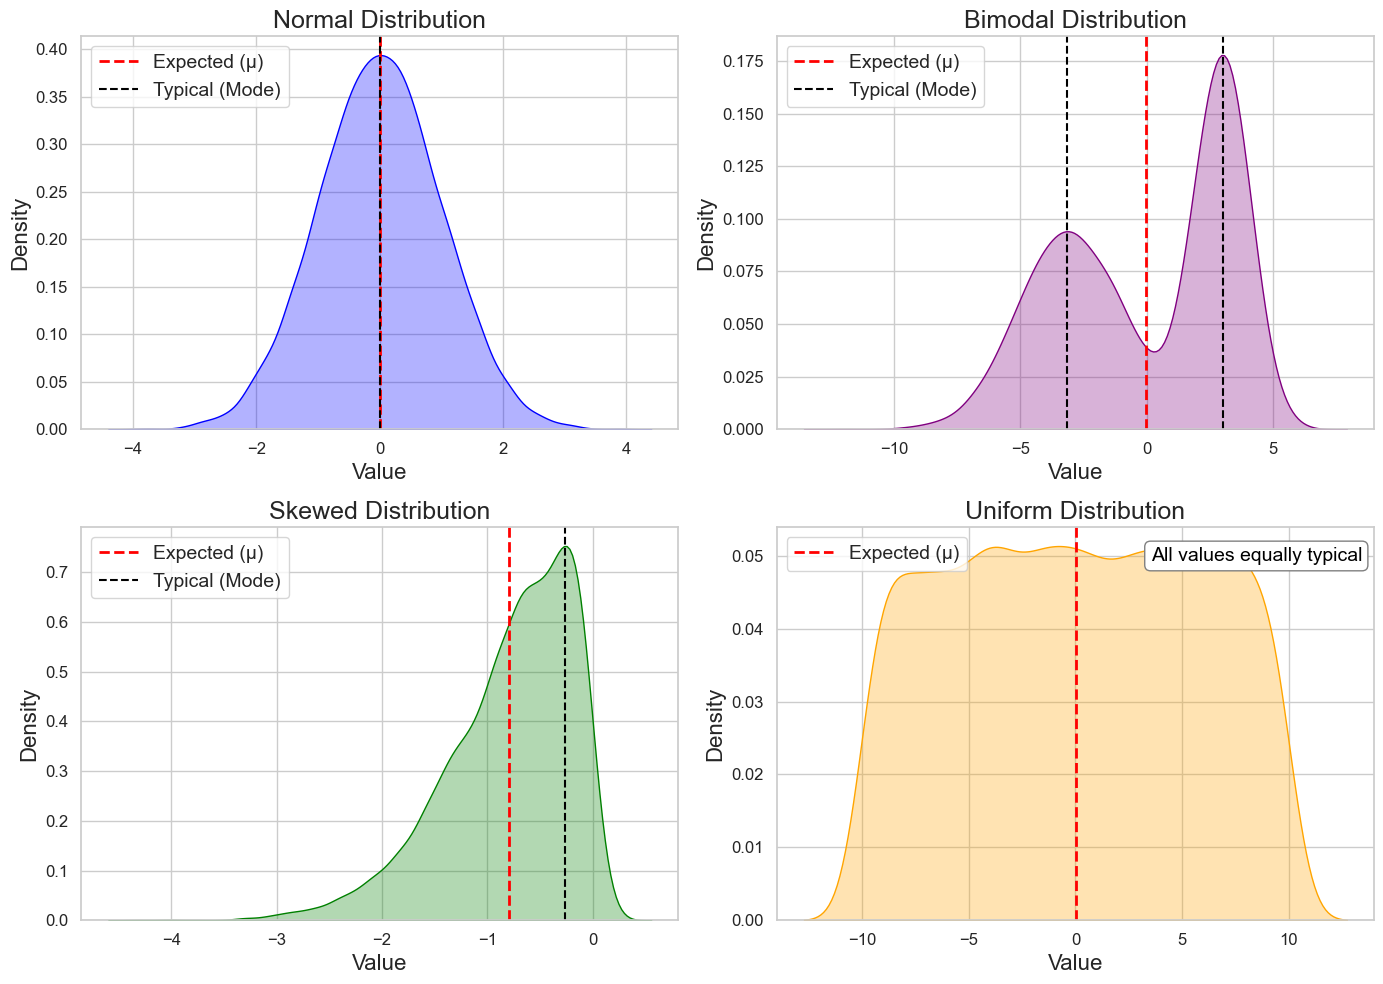

In [7]:
# Set seed for reproducibility
np.random.seed(42)

size = 10000

# Normal distribution data
mu_normal = 0
sigma_normal = 1
normal_data = norm(loc=mu_normal, scale=sigma_normal).rvs(size=size)

# Skewed distribution data
mu_skewed = 0
sigma_skewed = 1
skewed_data = skewnorm(a=-10, loc=mu_skewed, scale=sigma_skewed).rvs(size=size)

# Bimodal distribution data
mode_1, sigma_1 = -3, 2
mode_2, sigma_2 = 3, 1
bimodal_data = np.concatenate([
    norm(loc=mode_1, scale=sigma_1).rvs(size=size//2),
    norm(loc=mode_2, scale=sigma_2).rvs(size=size//2)
])

# Uniform distribution data
uniform_data = np.random.uniform(low=-10, high=10, size=size)

from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Function to find one or more modes using KDE and peak detection
def get_modes(data, data_size, num_peaks=2, distance=50):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), data_size)
    y_kde = kde(x_grid)
    peaks, _ = find_peaks(y_kde, distance=distance)
    peak_xs = x_grid[peaks]
    sorted_peaks = peak_xs[np.argsort(-y_kde[peaks])]
    return sorted_peaks[:num_peaks]

# List of distributions and their data
distributions = [
    ("Normal Distribution", normal_data, np.mean(normal_data), get_modes(normal_data, size, 1), "blue"),
    ("Bimodal Distribution", bimodal_data, np.mean(bimodal_data), get_modes(bimodal_data, size, 2), "purple"),
    ("Skewed Distribution", skewed_data, np.mean(skewed_data), get_modes(skewed_data, size, 1), "green"),
    ("Uniform Distribution", uniform_data, np.mean(uniform_data), None, "orange")
]

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for ax, (title, data, mean, modes, color) in zip(axs.flatten(), distributions):
    sns.kdeplot(data, ax=ax, color=color, fill=True, alpha=0.3)
    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel("Value", fontsize=labels_font)
    ax.yaxis.label.set_fontsize(labels_font)

    ax.axvline(mean, color='red', linestyle='--', lw=2, label="Expected (µ)")

    if title == "Uniform Distribution":
        ax.text(
            0.98, 0.95,  # x, y in axis fraction (top right corner)
            "All values equally typical",
            transform=ax.transAxes,  # interpret position in axis coords
            ha='right', va='top',  # align text box to the top-right corner
            fontsize=text_font,
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'),
        )

    else:
        for i, mode in enumerate(modes):
            label = 'Typical (Mode)' if i == 0 else None
            ax.axvline(mode, color='black', linestyle='--', label=label)

            
    ax.legend(loc='upper left', fontsize=text_font)
    ax.tick_params(axis='both', labelsize=tick_font)

plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'expected_vs_typical.png'))

plt.show()


---

# Back to error simulation land
## Model Stability

After taking a mental note of how `Expected` and `Typical` can differ on a distribution, I go with the `Expected` because it is what everyone else is using, and what most of the analysis and algorithms are designed to estimate.

The next step in understanding the model performance beside estimating the `Expected` (i.e., mean) value, is reporting the standard deviation.

Below, I simulate another error distribution that also has a mean of zero, but a standard deviation of 0.25 LogS. When compared to the previous error distribution of standard deviation 1, one can see clearly that one distribution will be more consistently around the zero than another.

This makes the error distribution with smaller standard deviation more preferable.

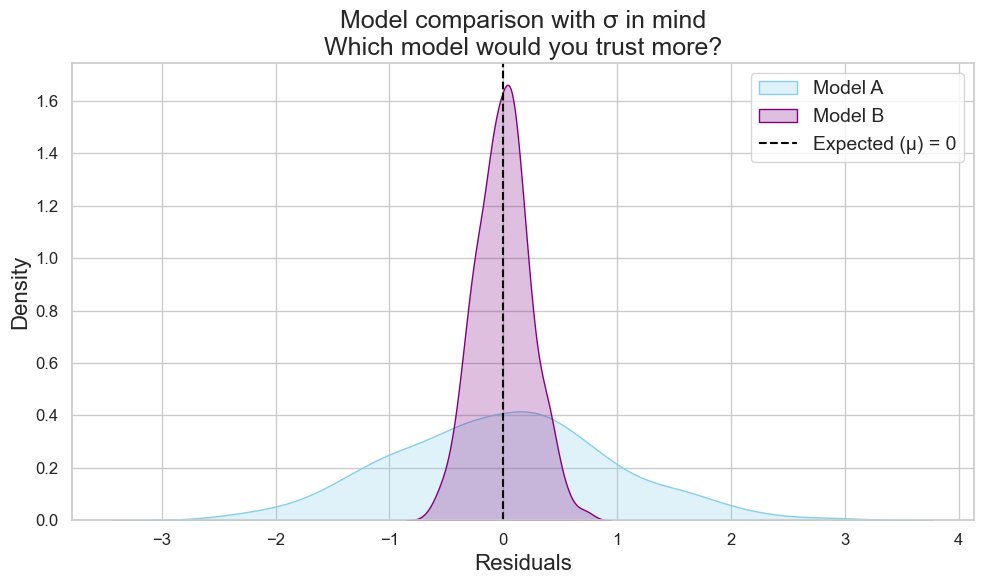

In [8]:
rng = np.random.default_rng(42)

mu_B = mu_A
sigma_B = 0.25

noise_B = rng.normal(mu_B, sigma_B, size=test_size)
test_pred_B = test_true + noise_B
residuals_B = test_pred_B - test_true  # Same as noise, this is how error is calculated in real ML application

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'purple']
for i, (model_name, predicted_sample) in enumerate({'Model A': residuals_A, 'Model B': residuals_B}.items()):
    sns.kdeplot(predicted_sample, label=model_name, color=colors[i], fill=True)
    if i == 1:
        plt.axvline(mu_A, color='black', linestyle='--', label=f'Expected (µ) = {mu_A}')


plt.title("Model comparison with σ in mind\nWhich model would you trust more?", fontsize=title_font)
plt.xlabel("Residuals", fontsize=labels_font)
plt.ylabel("Density", fontsize=labels_font)
plt.legend(loc='upper right', fontsize=text_font)
plt.tick_params(axis='both', labelsize=tick_font)
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'model_stability.png'))

plt.show()

## Sampling Uncertainty

We test a model on a test set of 400 molecules, we get an error distribution of mean zero and standard deviation of 1. Would testing our model on a different 200 molecule result in the same mean and standard deviation?

The answer is: Not likely.

The `Expected` value of a distribution can be estimated accurately only after running our model on a large number of molecules to converge to the final shape the distribution would take. This is the main assumption of "the law of large numbers" which govern the behaviour of the `Expected` value.

So, to understand what this means, I will start by assuming that I have access to a large test set of 10,000 molecules. I will draw them from my population, and I will call it `Gold Standard`

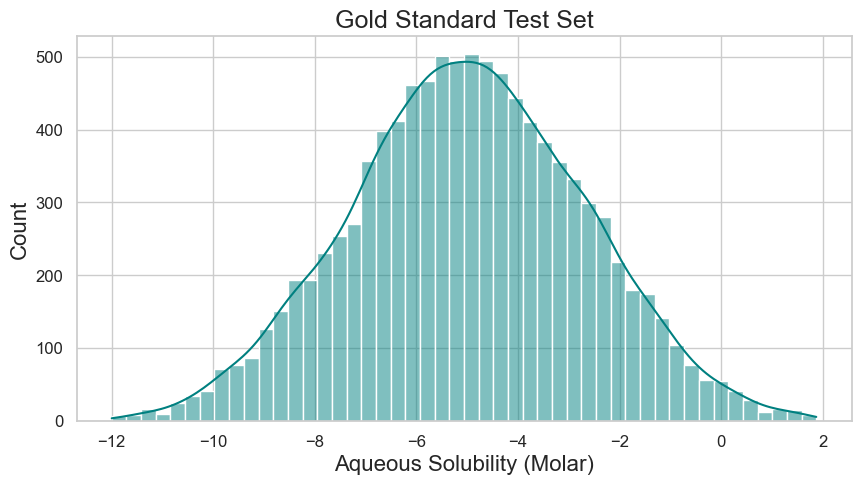

In [9]:
gold_standard_test_size = 10000
gold_standard_true = np.random.choice(imaginary_population, size=gold_standard_test_size, replace=False)

# Plot histogram of Gold Standard Test set
plt.figure(figsize=(10, 5))
sns.histplot(gold_standard_true, kde=True, color='teal')

plt.title("Gold Standard Test Set", fontsize=title_font)
plt.xlabel("Aqueous Solubility (Molar)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.tick_params(axis='both', labelsize=tick_font)
plt.show()

## Model performance on Gold Standard
Now, let's imagine that my model has provided predictions for these 10k molecules, and the residuals had a normal distribution of mean  0 and a standard deviation of 0.8 LogS.

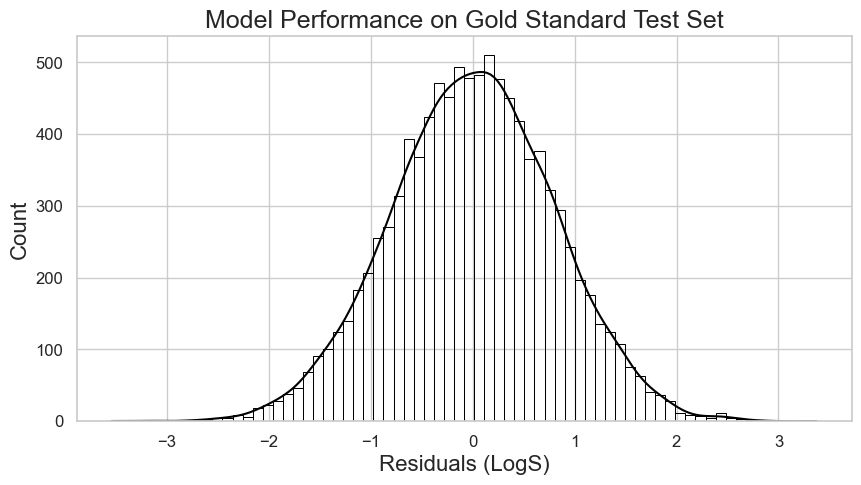

In [10]:
np.random.seed(40)
mu_gold_error = 0
sigma_gold_error = 0.8
gold_standard_pred = gold_standard_true + np.random.normal(loc=mu_gold_error, scale=sigma_gold_error, size=gold_standard_test_size)
model_true_performance = gold_standard_pred - gold_standard_true

# Plot histogram of Gold Standard Test set
plt.figure(figsize=(10, 5))
sns.histplot(model_true_performance, kde=True, color='black', fill=False)

plt.title("Model Performance on Gold Standard Test Set", fontsize=title_font)
plt.xlabel("Residuals (LogS)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.tick_params(axis='both', labelsize=tick_font)
plt.show()

## Model Performance on small test sets

Now, I will imagine that instead of having access to all the 10K molecules at once, my chemist was giving me only 200 molecules of interest every couple of months for 10 months.

These samples were varying in characteristics. Sometimes they were always on the low solubility scale, sometimes they were on the high scale, sometimes they were an even mix, etc. And my model was not performing as nicely on all of them. Sometimes it was overestimating, sometimes underestimating, sometimes getting it mostly right, etc.

I am making the assumptions that these samples are part of my `Gold standard` set. I just got access to them independently, and my model will perform the same on them as it would perform on them when being a part of the whole set.

So, to get the error distribution for these samples, I will simply draw 200 molecules from the `Gold Standard` error distribution for 10 times.
<br>Because I want my samples to vary between predicting nicely, and over or underpredicting, I will
1. Segment my `Gold Standard` set into quartiles.
2. Use the `dirichlet` function to randomly assign a percentage of datapoints to draw from each quartile.
    - This will result in error distributions of different shapes (e.g., normal, skewed, bimodal)

Then, I plot the 10 samples of 200 molecules each alongside the `Gold Standard` test set of 10K molecules at once.

What one will see is that, no single sample got the mean (µ) of the `Gold Standard` correctly.

However, all the samples, together, did something right! Wait for the next post to know what it is! 😉

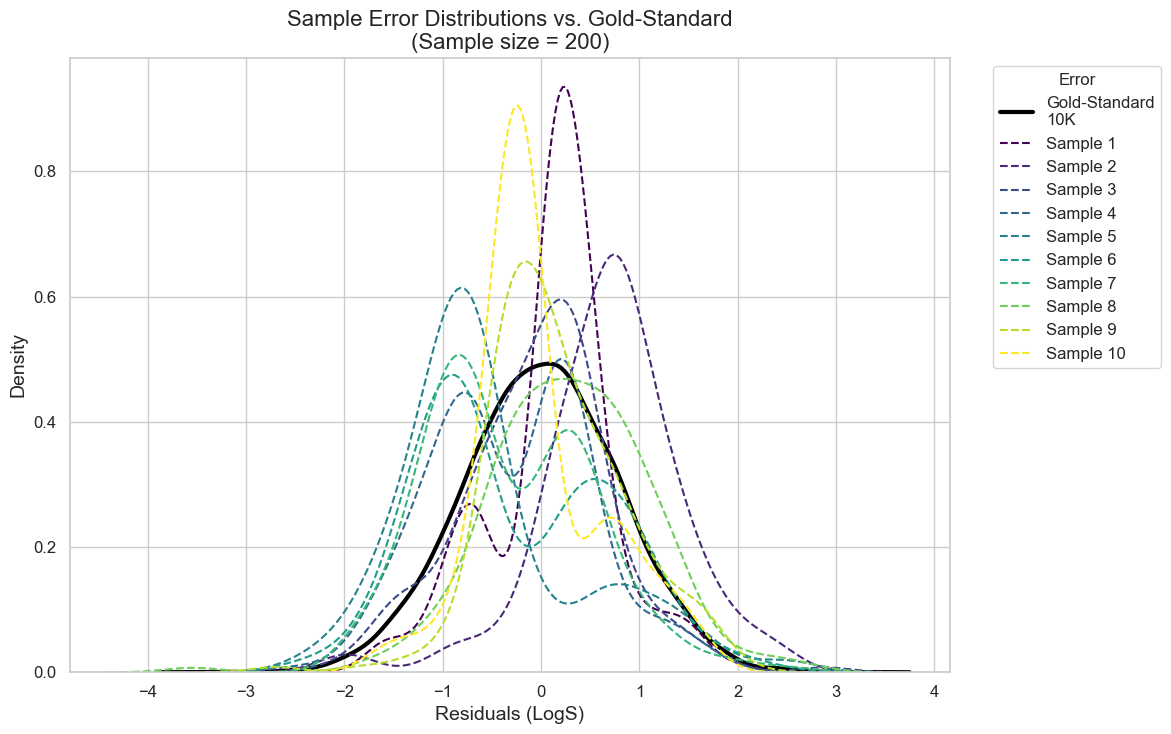

In [11]:
np.random.seed(40)
num_samples = 10
sample_size = 200

# Step 1: Compute quantiles (e.g. quartiles)
quantile_bins = pd.qcut(model_true_performance, q=4, labels=False, duplicates='drop')  # 0 = lowest, 3 = highest
gold_df = pd.DataFrame({'LogS': model_true_performance, 'bin': quantile_bins})

samples = []
labels = []

for i in range(num_samples):
    # Generate random percentages per quantile (must sum to 1). Different percentages will lead to different distribution shapes
    probs = np.random.dirichlet(alpha=np.ones(4), size=1).flatten()

    # Sample from each quantile bin
    counts = (probs * sample_size).astype(int)
    counts[-1] = sample_size - counts[:-1].sum()  # ensure total = sample_size

    data = []
    for q, n in enumerate(counts):
        available = gold_df[gold_df['bin'] == q]['LogS']
        if len(available) >= n:
            data.extend(np.random.choice(available, size=n, replace=False))
        else:
            data.extend(np.random.choice(available, size=n, replace=True))  # fallback if too few samples

    # Optional: add label that reflects distribution type and dominant quantile
    dominant_bin = np.argmax(probs)
    label = f"Sample {i+1}"

    samples.append(np.array(data))
    labels.append(label)


# Plotting
plt.figure(figsize=(12, 7.5))
sns.kdeplot(model_true_performance, label=f"Gold-Standard\n{len(model_true_performance)/1000:.0f}K", linewidth=3, color='black')

colors = plt.cm.viridis(np.linspace(0, 1, num_samples))
for i, (sample, label) in enumerate(zip(samples, labels)):
    sns.kdeplot(sample, label=label, linestyle='--', color=colors[i])

plt.title(f"Sample Error Distributions vs. Gold-Standard\n(Sample size = {sample_size})", fontsize=16)
plt.xlabel("Residuals (LogS)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title="Error", title_fontsize=12, fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'sampling_uncertainty.png'))
plt.show()


---

# Wrapping Up

- One needs to test their model on **enough** new molecules to estimate a model’s **expected error (µ)**.
- The **expected** error may differ from the **typical** error depending on the distribution shape.
- **Standard deviation (σ)** tells us how **stable** the model is.
  - If two models have close expected errors, the one with **lower σ** is **more reliable**.
- A **large**, **representative** test set gives the most trustworthy performance.
  - A **small** test set provides only an estimate — subject to the quirks of the included data.

if one **doesn’t** have access to a large test set (which is usually the case in our field), one needs to wait my next blog post to know what else can be done 😉